In [1]:
### Import Libraries 
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
import seaborn as sns
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input
from sklearn.model_selection import train_test_split


In [2]:
### Reading csv data files using pandas dataframe 

train = pd.read_csv("C:/Users/Vishal Patil/Desktop/Data Science/Kaggle/jigsaw_toxic_comment_classification/train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("C:/Users/Vishal Patil/Desktop/Data Science/Kaggle/jigsaw_toxic_comment_classification/test.csv", encoding = "ISO-8859-1")

In [3]:
### Checking nulls in both the datasets

print("Nulls in training dataset",train.isnull().sum())
print("\nNulls in test dataset",test.isnull().sum())

### There are no missing values in both the datasets

Nulls in training dataset id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Nulls in test dataset id              0
comment_text    0
dtype: int64


In [4]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments

Text(0.5, 0, 'Labels')

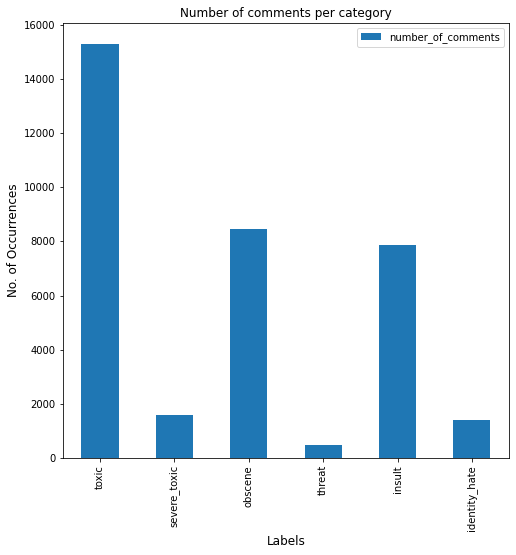

In [5]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments

,0,Total no. of sentences,Total No. of labels in a sentence
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


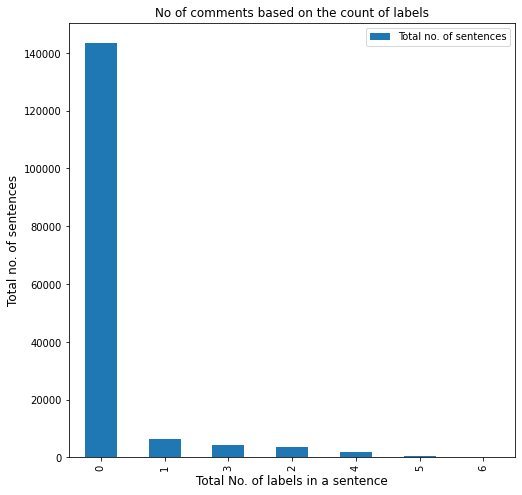

In [6]:
### Visualization 2

### Bar graph of Total No. of labels in a sentence against Total no. of sentences
### This visualization is helpful in identifying whether a sentence belongs to only one category or many categories

dataframe = pd.DataFrame(pd.DataFrame(train[train.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
dataframe["Total no. of sentences"]=dataframe[0]
dataframe["Total No. of labels in a sentence"]=dataframe.index
dataframe.plot(x="Total No. of labels in a sentence", y="Total no. of sentences", kind='bar',figsize=(8,8))
plt.title("No of comments based on the count of labels")
plt.ylabel('Total no. of sentences', fontsize=12)
plt.xlabel('Total No. of labels in a sentence', fontsize=12)
dataframe

### From the below graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels(class 0).
### we can observe that a single sentence can have multiple labels. It can be a toxic sentence or it can be a toxic as well as obscene senetence.

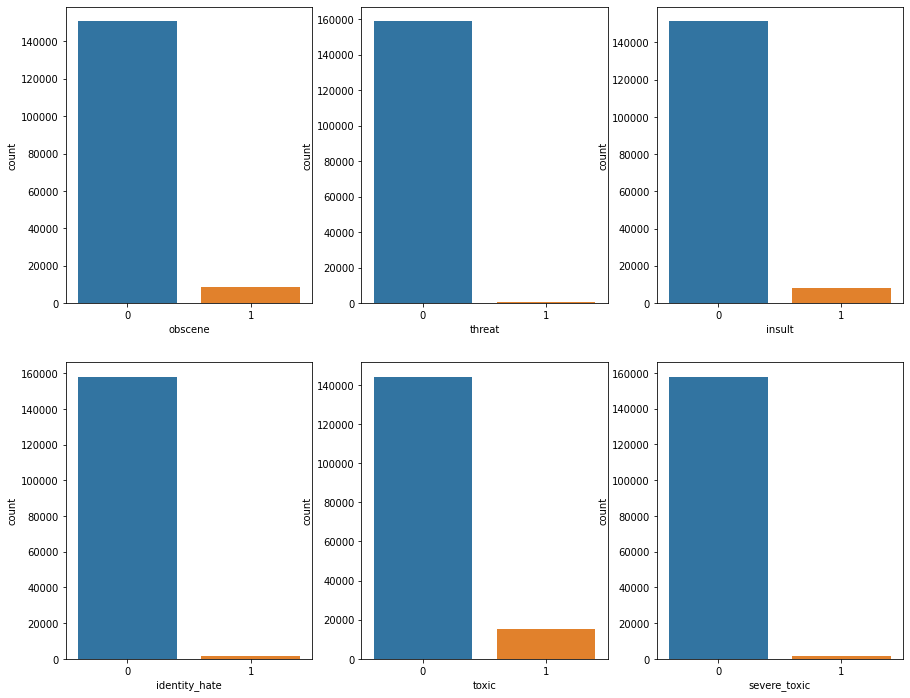

In [7]:
### Visualization 3

### Graph of individual class against the total no. of labelled and unlabelled sentences for the same class

fig, plots = plt.subplots(2,3,figsize=(15,12))
plot1, plot2, plot3, plot4, plot5, plot6 = plots.flatten()
sns.countplot(train['obscene'], ax = plot1)
sns.countplot(train['threat'], ax = plot2)
sns.countplot(train['insult'], ax = plot3)
sns.countplot(train['identity_hate'], ax = plot4)
sns.countplot(train['toxic'], ax = plot5)
sns.countplot(train['severe_toxic'], ax = plot6)

### From this graph it can be concluded that every class(category) is having higher no. of unlabelled sentences(0) as compared
### to labelled sentences(1)

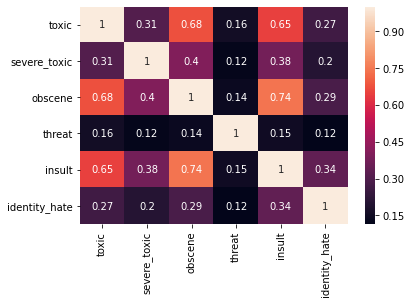

In [8]:
### Visualization 4

### Correlation between different variables
### Correlation helps us finding relationship/dependency between different variables. 

target_data = train.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Correlation coefficient ranges from -1 to 1. Values always range between -1 imply strong negative relationship
### between variables and +1 imply a strong positive relationship between variables. 
### Values at or close to zero imply weak or no linear relationship. 
### From the correlation matrix(graph), it can be concluded that some labels are highely correlated. Those varibles are mentioned below 
### (Correlation coefficient for insult-obscene is 0.74, Correlation coefficient for toxic-obscene is 0.68 and Correlation coefficient for toxic-insult is 0.65).

In [9]:
### From visualization we can conclude following things
### 1) A single sentence can have multiple labels (categories)
### 2) Some labels are highely correlated to each other
### 3) This is multi label classification problem 

In [10]:
### Data cleaning/Preparation 

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)      ### conversion of contraction words to expanded words
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)                                                 ### removing non-word characters
    text = re.sub('[^A-Za-z\' ]+', '',text)                                        ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])    ### Stopwords removal
    return text

train["comment_text"] = train["comment_text"].apply(clean_text)
test["comment_text"] = test["comment_text"].apply(clean_text)


In [11]:
### Splitting up the labels and data
### Training dataset is splitted into 2 parts. 1st part includes the training data(train_data) and 2nd part includes labels(train_label) 
### associated with the training data
### Test dataset is having only 1 part i.e. test data which is used to predict the labels. 

train_data = train["comment_text"]
test_data = test["comment_text"]
train_label=train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]


In [12]:
### Creating corpus of words and coverting it into integer and then susbstituing it in sentences - prepare tokenizer
tokenizer = Tokenizer(num_words = 40000) #40000 words are used here
tokenizer.fit_on_texts(train_data)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(train_data)
test_final = tokenizer.texts_to_sequences(test_data)

In [13]:
### Padding - Every sentence is unequal in length. We need to have all the sentence equal in lengths
### If length of sentence is less than 150 then padding will increase sentence length to 150 by adding zeros, if its greater
### than 150 then it will reduce the length of sentence to 150 by trimming the words

train_padded =pad_sequences(train_final, maxlen=150)
test_padded =pad_sequences(test_final, maxlen=150)
print("Shape of training data",train_padded.shape)
print("Shape of testing data",test_padded.shape)


Shape of training data (159571, 150)
Shape of training data (153164, 150)


In [19]:
### Building a model
### I have built a sequential model using LSTM. Initial layer contains a word embedding layer having 128 hidden units. 
### Input to the LSTM model is given in the shape of an array of (159571, 150). There are 6 main classes and every class is having 2 sub classes.
### For every Input observation, there are 6 labels. 
### I have used 2 LSTM layer with 64 hidden units. 1 Dense layer which is an output layer. Dropout probability is set to 0.2 for
### 2 lSTM layers which will dropout the 20 percent of neuron automatically while training.Dropout resolves the problem of overfitting. 
### Output layer contains 6 hidden units. I have used sigmoid activation function in the output layer. The reason behind using
### sigmoid activation function in the output layer is because we have multi label classification problem.
### Every class(label) is having 2 more classes i.e.0 and 1 to predict. 

model = Sequential()
model.add(Embedding(40000, 128))
model.add(LSTM(units = 64, dropout = 0.2,return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         5120000   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 5,202,822
Trainable params: 5,202,822
Non-trainable params: 0
_________________________________________________________________


In [20]:
### Compiling the model and training the model using training dataset
### We need to define loss function to measure the loss. Our problem is multi label multi classification problem.
### Hence I decided to take loss function as binary_crossentropy. (Reference - https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/)
### Adam optimizer is best for this problem. I tried RMSprop also but didn't get good accuracy. So decided to go with adam optimizer
### accuracy metric has been used. Dataset is divided into training and validation set. 
### We got an accuracy of 97.79% on validation dataset. batch_size is 32 . 
### These are the Number of samples that goes through the network at a time and calculates the loss by updating the parameters.
### I used only 1 epoch because I got almost 97% accuracy in 1 iteration.
### Submission from the competition was evaluated on the basis of AUC. Hence i decided to use AUC metrics.
### AUC is area under the curve. It can be calculated from receiver operating curve

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_val, y_train, y_val = train_test_split(train_padded, train_label, shuffle = True, random_state = 123)
model.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 1852s 495ms/step - loss: 0.0704 - auc: 0.9587 - val_loss: 0.0495 - val_auc: 0.9779


In [31]:
### Prediction for test data
predict = model.predict(test_padded)


In [33]:
print("Predicted values are",predict)

Predicted values [[9.76957679e-01 3.13972712e-01 9.33733821e-01 5.85845709e-02
  7.25662410e-01 1.31143481e-01]
 [4.64612246e-03 8.62794841e-05 6.15268946e-04 4.75585461e-04
  1.04561448e-03 3.88711691e-04]
 [7.90655613e-03 1.19516531e-04 8.71986151e-04 7.25209713e-04
  1.61722302e-03 5.64515591e-04]
 ...
 [2.66641378e-03 6.34066237e-05 4.41044569e-04 3.02791595e-04
  6.65843487e-04 2.63273716e-04]
 [2.61595845e-03 6.18302802e-05 4.32729721e-04 2.99215317e-04
  6.54280186e-04 2.59876251e-04]
 [9.76678848e-01 1.22220516e-01 8.57039690e-01 3.67633402e-02
  7.10305631e-01 8.47513676e-02]]


In [66]:
### predicted probabilities of each id in the test set, for all the target columns

target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.976958,0.313973,0.933734,0.058585,0.725662,0.131143
1,0000247867823ef7,0.004646,0.000086,0.000615,0.000476,0.001046,0.000389
2,00013b17ad220c46,0.007907,0.000120,0.000872,0.000725,0.001617,0.000565
3,00017563c3f7919a,0.003322,0.000073,0.000560,0.000349,0.000831,0.000297
4,00017695ad8997eb,0.007922,0.000117,0.000884,0.000717,0.001631,0.000553


In [ ]:
#### Complete description of classification system using neural networks

## This classification system is built using LSTM which is a special type of RNN's. I have used Keras library to build neural network.
## Recurrent Neural networks are used mostly for sequential data. We have sequential data(sentences). RNN's store information in their "memory".
## Recurrent Neural networks stores the information about the computations which has already been performed.
## Variety of RNN achitectures are available based on the need of the user. I have used LSTM which is a special type of RNN.
## Even though RNN are good for sequence modelling, it still have issues and it tends to have vanishing gradient problem.
## Vanishing gradient problem is faced by neural networks which uses activation function having small gradient(0 to 1).
## During backpropagation phase, these gradients either tend to become 0 or they vanishes. This happens because RNN's are not
## capable of handling long-term dependencies. In order to avoid vanishing gradient problem LSTM are developed. 
## LSTM comes with LSTM cell. It helps to model and keep track of long term dependencies. 

### Process performed in this classification model are mentioned below.
## Reading the dataset using pandas dataframe and checking whether it contains any null observations or not. There are no nulls in this dataset.
## Many people clean the data first and then perform visualizations. I performed visualizations first. 
## I created 4 visualizations. 
## 1st visualization is a Bar graph of total number of comments per label. It is helpful in identifying the total number of comments per label
## 2nd visualization is a Bar graph of Total No. of labels in a sentence against Total no. of sentences. 
## From 2nd visualization we can observe whether a sentence belongs to only one category or many categories. We can say that
## there are many sentences which are not classified(label 0) but many sentences falls under more than 1 category.
## 3rd Visualization is a Graph of individual class against the total no. of labelled and unlabelled sentences for the same class. 
## 4th Visualization is a Correlation graph(matrix) between different variables

## From visualization we can conclude that,  1) A single sentence can have multiple labels (categories).
## 2) Some labels are highely correlated to each other.
## 3) This is multi label classification problem. Hence we can use sigmoid function in the output layer.

### Next part includes cleaning the data. Data cleaning part is performed on the input text. 
## I created a function, which performs below activities: 
## 1) conversion of contraction words to expanded words , 2) removing stopwords , 3) lowercasing the words
## 4) removing the non - alphanumeric characters   5) removing the extra spaces between words

### Once we have cleaned the data, next part is creating input feature vectors.  
## Tokenizer class from keras library is used. 40000 words has been selected based on the frequency of the words and assigned a number using keras tokenizer
## Training dataset consists of sentences. Every sentence is made up of words. The number given to the words by the keras 
## tokenizer are used to build up a sentence. Padding is used to fix the sentence length to 150 words per sentence. 


### Input features are generated. Now its time to build a model. Model contains an Input embedding layer of 128 Hidden units.
## Models contains 2 LSTM layers of 64 Hidden units and 1 output layer of 6 Hiddent units having sigmoid activation function.
##Input to the neural network is given in the shape of (159571, 150).

### Next part is compiling the model and training it on training dataset. Training dataset is divided in training and validation dataset
##  Binary_crossentropy is used as a loss function. Adam optimizer is used. Accuracy metric has been used.
## batch_size is 32 . These are the Number of samples that goes through the network at a time and calculates the loss by
## updating the parameters.I used only 1 epoch because I got almost 97% accuracy in 1 iteration.
